<a href="https://colab.research.google.com/github/adrianaleticiamartinez/MCD/blob/main/ML1_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Social Media Bot Detection

## Information about the project
 Project Name: Social Media Bot Detection

University Name: Universidad Panamericana

Course Name: Machine Learning I

Team Members: David Arturo Hernández Gómez , Adriana Leticia Martínez Estrada

Date: December 5th, 2023

Code Version: 1.3

**Project Description:** This project aims to develop a machine learning model to distinguish between human and bot behavior on social media platforms.

**Execution Instructions:** Run all cells in sequence to preprocess the data, train the models, and evaluate their performance.


## Implementation

In [ ]:
# Necessary library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

In [ ]:
# Global variables
DATASET_BOT_PATH = 'https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/botwiki-2019.tsv'
DATASET_BOT_COMPLEMENT_PATH = "https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/botwiki-2019_tweets.json"
DATASET_USER_PATH = 'https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/verified-2019.tsv'
DATASET_USER_COMPLEMENT_PATH = 'https://raw.githubusercontent.com/adrianaleticiamartinez/MCD/main/verified-2019_tweets.json'

In [ ]:
#Cleaning single field registries
def columns_analize(df, campos_unicos):
  columns_to_drop = []
  for i in df.columns:
    if len(list(df[i].value_counts())) <= campos_unicos:
      columns_to_drop.append(i)
  return columns_to_drop

In [ ]:
# Main data preprocessing and analysis functions
def preprocess_data():
    """
    Preprocesses the raw data by cleaning and encoding features.

    Returns:
        X_train_preprocessed (array): Preprocessed training features.
        X_test_preprocessed (array): Preprocessed testing features.
        y_train (array): Encoded training labels.
        y_test (array): Encoded testing labels.
    """
    #--Extraction--
    print("x")

    #Reading bot information
    data_raw_bot = pd.read_csv(DATASET_BOT_PATH,sep='\t', header=0,  names=['id', 'label'])
    data_raw_bot_complement = pd.read_json(DATASET_BOT_COMPLEMENT_PATH)
    df_unpacked_bot = pd.json_normalize(data_raw_bot_complement['user'])
    joined_bot_data = pd.merge(data_raw_bot, df_unpacked_bot, on="id")
    print("x")

    #Reading user information
    data_raw_user = pd.read_csv(DATASET_USER_PATH,sep='\t', header=0,  names=['id', 'label'])
    data_raw_user_complement = pd.read_json(DATASET_USER_COMPLEMENT_PATH)
    df_unpacked_user = pd.json_normalize(data_raw_user_complement['user'])
    joined_user_data = pd.merge(data_raw_user, df_unpacked_user, on="id")

    #Full data
    frames = [joined_bot_data, joined_user_data]
    full_data = pd.concat(frames)

    #--Transformation--
    size_Data = len(full_data)
    full_data = full_data.drop(columns = ["id_str", "name"])



    unique_value_all_columns = columns_analize(full_data, 1)

    full_data = full_data.drop(columns = unique_value_all_columns)

    only_two_values_columns = columns_analize(full_data, 5)

    columns_to_drop = []
    for i in only_two_values_columns:
      percentage_same_value = [(x / size_Data) for x in list(full_data[i].value_counts())]
      for j in percentage_same_value:
        if j > 0.9:
          columns_to_drop.append(i)

    full_data = full_data.drop(columns = columns_to_drop)

    #Droping all columns that contain an URL
    columns_with_url = full_data.filter(regex='url', axis=1)

    full_data = full_data.drop(columns = columns_with_url.columns)

    #Droping all columns with color data
    columns_with_color = full_data.filter(like='color', axis=1)

    full_data = full_data.drop(columns=columns_with_color.columns)

    #Droping creation date column
    full_data = full_data.drop(columns=["created_at"])
    #Droping description column

    full_data = full_data.drop(columns=["description"])

    #Data Segmentation

    X = full_data[["location", "followers_count", "friends_count", "listed_count", "favourites_count", "geo_enabled", "verified", "statuses_count", "profile_background_tile", "profile_use_background_image", "has_extended_profile", "default_profile"]]
    y = full_data["label"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=117)

    #Pipelines
    attributes_number = Pipeline(steps = [
        ('null_replacement', SimpleImputer(strategy = 'mean')),
        ('scaling', StandardScaler())
    ])

    attributes_category = Pipeline(steps = [
        ('null_replacement', SimpleImputer(strategy = 'most_frequent')),
        ('encoding', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
    ])

    attributes_preprocess = ColumnTransformer(transformers = [
        ('number', attributes_number, X_train.select_dtypes(include='number').columns.tolist()),
        ('category', attributes_category, X_train.select_dtypes(include='category').columns.tolist())
    ])
    label_encoding = LabelEncoder()

    y_train = label_encoding.fit_transform(y_train)
    y_train
    preprocessor = ColumnTransformer(transformers=[
        ('number', attributes_number, X_train.select_dtypes(include='number').columns.tolist()),
        ('category', attributes_category, X_train.select_dtypes(include='category').columns.tolist())
    ])
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_test_preprocessed = preprocessor.transform(X_test)

    y_test_encoded = label_encoding.transform(y_test)

     # Aquí tú código
    # ...


    return X_train_preprocessed, X_test_preprocessed, y_train, y_test_encoded

In [ ]:
def train_models(X_train_preprocessed, y_train):
    """
    Trains Ridge and Decision Tree classifiers.

    Args:
        X_train (array): Training features.
        y_train (array): Training labels.

    Returns:
        ridge_model (RidgeClassifier): Trained Ridge classifier.
        tree_model (DecisionTreeClassifier): Trained Decision Tree classifier.
    """
    #--L2 (RidgeClassifier)--

    ridge_model = RidgeClassifier()
    ridge_model.fit(X_train_preprocessed, y_train)

    #--tree_model (DecisionTreeClassifier)
    tree_model = DecisionTreeClassifier()
    tree_model.fit(X_train_preprocessed, y_train)

     # Aquí tú código
    # ...

    return ridge_model, tree_model

In [ ]:
def evaluate_models(X_test_preprocessed, y_test_encoded, ridge_model, tree_model):
    """
    Evaluates the performance of the trained models.

    Args:
        X_test (array): Testing features.
        y_test (array): Testing labels.
        ridge_model (RidgeClassifier): Trained Ridge classifier.
        tree_model (DecisionTreeClassifier): Trained Decision Tree classifier.
    """
    y_pred_ridge = ridge_model.predict(X_test_preprocessed)

    y_pred_tree = tree_model.predict(X_test_preprocessed)

    print("Evaluación de RidgeClassifier:")
    print(classification_report(y_test_encoded, y_pred_ridge))
    print("AUC-ROC:", roc_auc_score(y_test_encoded, ridge_model.decision_function(X_test_preprocessed)))
    ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_ridge)
    plt.show()


    # Evaluación de DecisionTreeClassifier
    print("Evaluación de DecisionTreeClassifier:")
    print(classification_report(y_test_encoded, y_pred_tree))
    print("AUC-ROC:", roc_auc_score(y_test_encoded, tree_model.predict_proba(X_test_preprocessed)[:, 1]))
    ConfusionMatrixDisplay.from_predictions(y_test_encoded, y_pred_tree)
    plt.show()

    # Aquí tú código
    # ...

x
x
Evaluación de RidgeClassifier:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       209
           1       0.74      1.00      0.85       596

    accuracy                           0.74       805
   macro avg       0.37      0.50      0.43       805
weighted avg       0.55      0.74      0.63       805

AUC-ROC: 0.9713239780353874


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


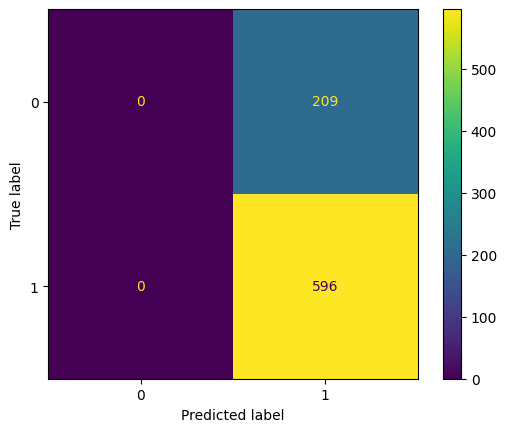

Evaluación de DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       209
           1       0.98      0.98      0.98       596

    accuracy                           0.97       805
   macro avg       0.96      0.96      0.96       805
weighted avg       0.97      0.97      0.97       805

AUC-ROC: 0.9627781702578594


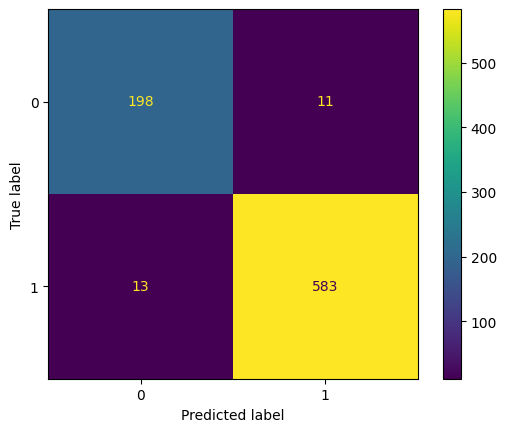

In [ ]:
# Main script execution
if __name__ == "__main__":
    # Data preprocessing
    X_train_preprocessed, X_test_preprocessed, y_train, y_test_encoded = preprocess_data()

    # Model training
    ridge_model, tree_model = train_models(X_train_preprocessed, y_train)

    # Model evaluation
    evaluate_models(X_test_preprocessed, y_test_encoded, ridge_model, tree_model)